# 10/16 Redoing (again) current restructure_data_compute_transports

In [466]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [467]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [468]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


/tmp/ipykernel_107252/4089359426.py:11: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [469]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.0060-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [470]:
dss['maxLevelCell'] = mesh.maxLevelCell

In [471]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

In [472]:
# get edges and vertices of mask made from transect from algorithm
alg_edges, alg_vertices, dsMasks = mps.open_transect_from_alg(mesh)

# get edges and vertices of mask made from mask
# get edges and vertices of mask made from mask
mask_edges, mask_vertices, mask = mps.open_from_mask(mesh)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks
Opening LS_test_transect_from_mask.nc file as mask


# Set up choice of coordinates

In [473]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

In [ ]:
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(mesh.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges

# we now have a dataset with cells and edges that are bordering the transect surrounding the mask

dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

# create mask so that land cells are NaNs

We will take an average of the `TWO` cells across a single `nEdge`. But we also have to deal with land cells. We apply a mask (i.e., replace with `NaNs`) to remove the land cells, of which there are two types:

>- Land cells that have no value (`nCells = -1`).
>- Land cells that are given a small datavariable value (e.g. `timeMonthly_avg_layerThickness == 0`) to represent land cells that sit below ocean cells.


In [555]:
# make land cells that have no value (nCells = -1) NaNs
xr_cellsOnTransectEdges_minus1 = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges).where(xr_cellsOnTransectEdges >= 0)

# make land cells that are given a small datavariable to represent land NaNs
# keep cells where the layer thickness is not a nan (would be a NaN from previous operation)
# keep cells where the layer thickness > 0 
# by applying the mask based on layerThickness, all other datavariables will also have nans in the same location
# (layerThickness = 0 tells us there is land at that location)

ocean_only = (~np.isnan(dss_transect_edges.timeMonthly_avg_layerThickness)) & (dss_transect_edges.timeMonthly_avg_layerThickness > 0)
dss_transect_edges_NaNs = xr_cellsOnTransectEdges_minus1.where(ocean_only)


Text(0.5, 0.98, 'potentialDensity')

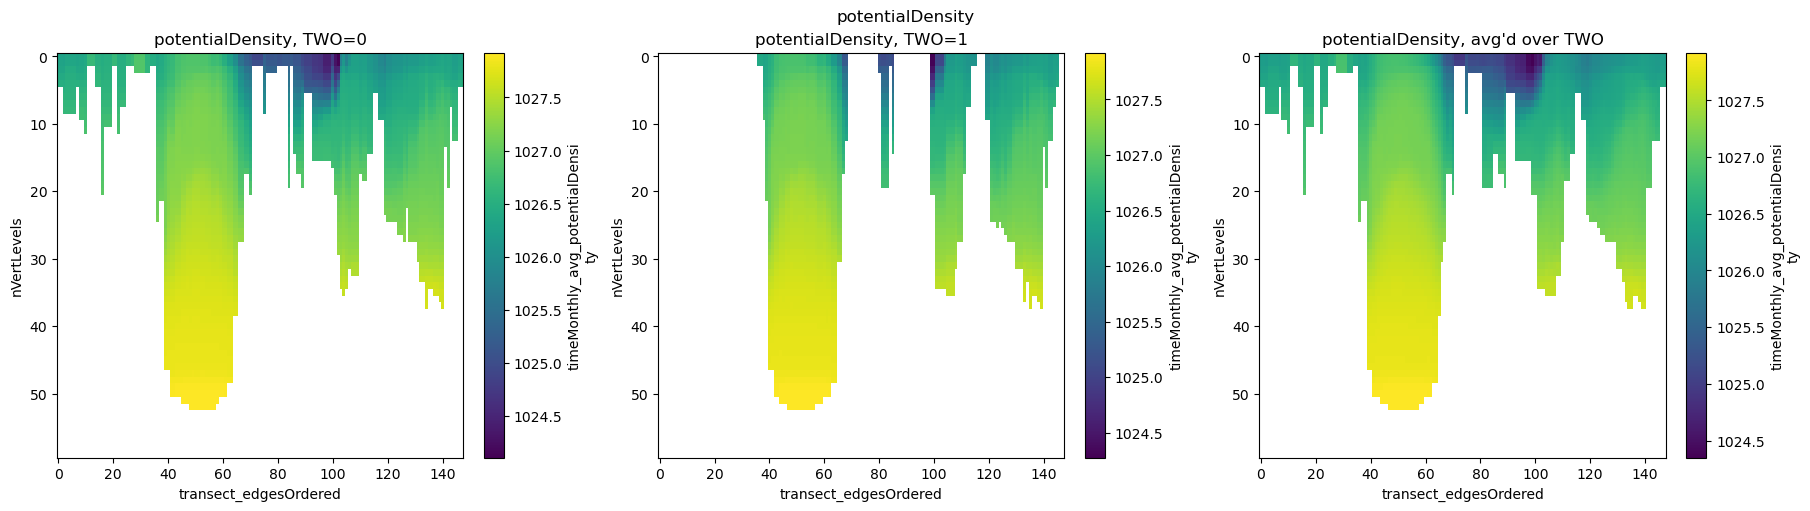

In [556]:
# plot density
fig, ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True, figsize=(18,5))

dss_transect_edges_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly']).isel(TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[0])

dss_transect_edges_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly']).isel(TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[1])

dss_transect_edges_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[2])


ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].set_title('potentialDensity, TWO=0')
ax[1].set_title('potentialDensity, TWO=1')
ax[2].set_title('potentialDensity, avg\'d over TWO')
fig.suptitle('potentialDensity')

Text(0.5, 0.98, 'layerThickness')

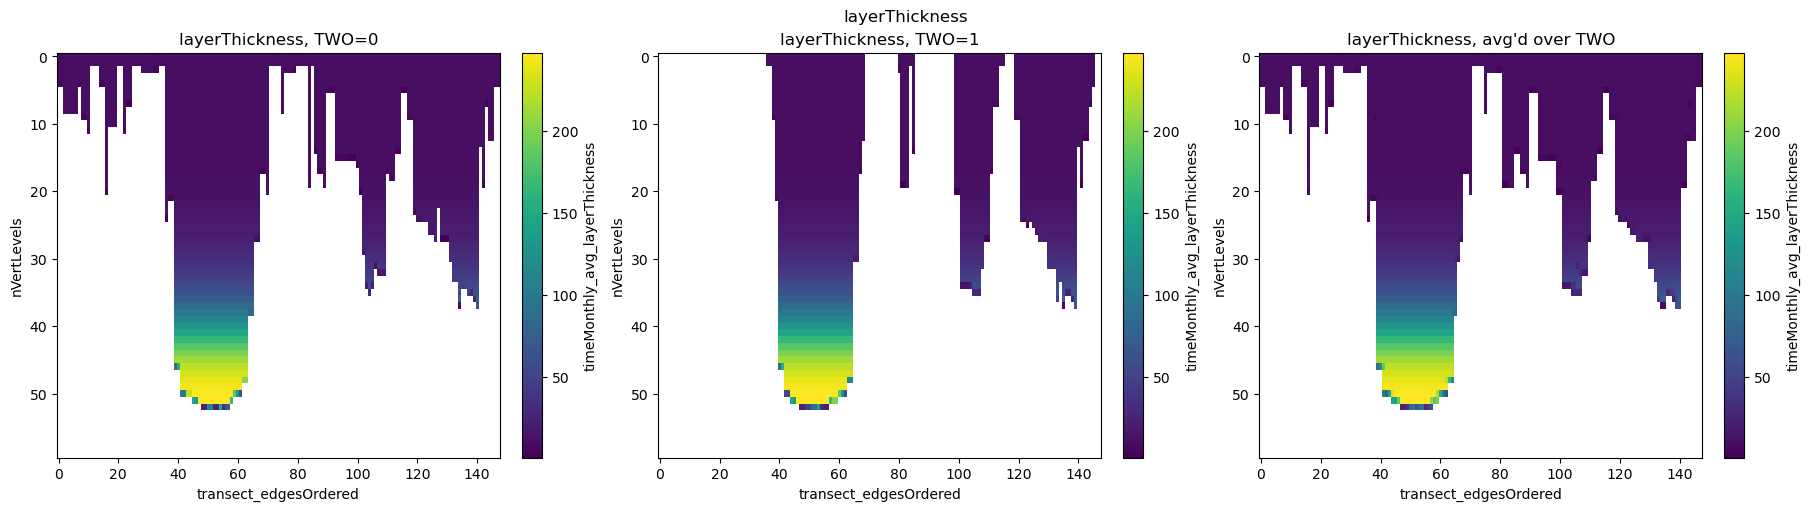

In [557]:
# plot layer thickness
fig, ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True, figsize=(18,5))

dss_transect_edges_NaNs.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly']).isel(TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[0])

dss_transect_edges_NaNs.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly']).isel(TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[1])

dss_transect_edges_NaNs.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[2])


ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].set_title('layerThickness, TWO=0')
ax[1].set_title('layerThickness, TWO=1')
ax[2].set_title('layerThickness, avg\'d over TWO')
fig.suptitle('layerThickness')

# calculate transport

## calculate velocity into mask

In [559]:
def calculate_velo_into_mask(ds, mesh, mask):
    ds['veloIntoMask'] = ds.timeMonthly_avg_normalVelocity * 0
    
    # .isel the mesh to only get the sorted edges on the transect (identified already in dss_transect_edges
    mesh_transect_edges = mesh.isel(nEdges = dss_transect_edges.nEdges)
    
    # find transect edges that border land using the cellsOnEdge variable from the mesh
    xr_transect_edgesOnLand_TWO0 = mesh_transect_edges.nEdges.where(np.isin(mesh_transect_edges.cellsOnEdge.isel(TWO=0),0))
    xr_transect_edgesOnLand_TWO1 = mesh_transect_edges.nEdges.where(np.isin(mesh_transect_edges.cellsOnEdge.isel(TWO=1),0))
    xr_transect_edgesOnLand = np.union1d(xr_transect_edgesOnLand_TWO0, xr_transect_edgesOnLand_TWO1)
    
    # find transect edges that border ocean (all transect edges NOT bordering land)
    xr_transect_edgesOnOcean = np.setxor1d(edges, xr_transect_edgesOnLand)
    
    # find the cells that lie on the transect open ocean edges
    n_transect_cellsOnOceanEdges = mesh_transect_edges.cellsOnEdge
    xr_transect_cellsOnOceanEdges = mps.n_to_xr_idx(n_transect_cellsOnOceanEdges)
    
    # select all the cells inside the mask
    xr_cells_inside, ignore_xr_edges_inside, ignore_xr_vertices_inside = mps.xr_inside_mask_info(mesh,mask)
    
    
    # determine if the normal velocity points into or out of the mask 
    for i in range(0,len(xr_transect_cellsOnOceanEdges)):
        for j in range(0,len(ds.xtime_startMonthly)):
            cellsOnSelectedEdge = xr_transect_cellsOnOceanEdges.isel(nEdges = i)
            selectedEdge = np.int32(mesh_transect_edges.nEdges.isel(nEdges = i))
            selectedMonth = ds.xtime_startMonthly.isel(xtime_startMonthly=j)
    
            if cellsOnSelectedEdge.isel(TWO=0).isin(xr_cells_inside): # if A is inside the mask
                ds.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)] = ds.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges = selectedEdge)] * -1
    
            elif cellsOnSelectedEdge.isel(TWO=1).isin(xr_cells_inside): # if B is inside the mask
                ds.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)] = ds.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges = selectedEdge)] * 1

    return ds, mesh_transect_edges, xr_transect_cellsOnOceanEdges

In [560]:
dss_transect_edges_vIM, mesh_transect_edges, xr_transect_cellsOnOceanEdges = calculate_velo_into_mask(dss_transect_edges_NaNs, mesh, mask)


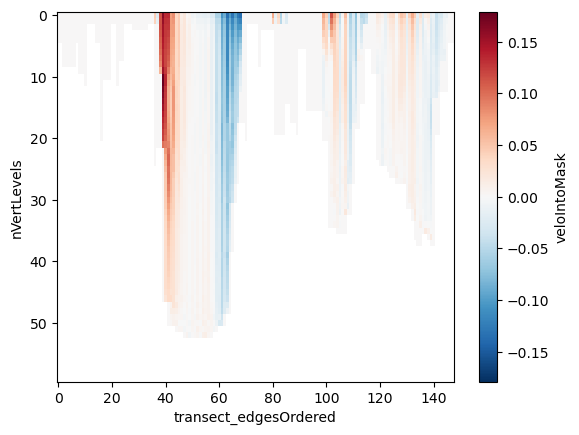

In [561]:
dss_transect_edges_vIM.veloIntoMask.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()

## calculate the cross-sectional area of the grid cell

In [562]:
# calculate the area of the edge-layerThickness plane that the normal velocity moves through
# interpolate layer thickness onto nEdges
dss_transect_edges_vIM['timeMonthly_avg_layerThickness_Edge'] = dss_transect_edges_vIM.timeMonthly_avg_layerThickness.mean(dim='TWO')

# get the edge length for all edges in transect
mesh_transect_edges_dv = mesh_transect_edges.dvEdge

# calculate the cross-sectional area of the transect by multiplying the layer-thickness of the edge by the length of the edge
transect_area = dss_transect_edges_vIM.timeMonthly_avg_layerThickness_Edge * mesh_transect_edges_dv

## calculate transport into the mask

In [563]:
transport = transect_area * dss_transect_edges_vIM.veloIntoMask / 10**6
dss_transect_edges_vIM['transportIntoMask_Sv'] = transport

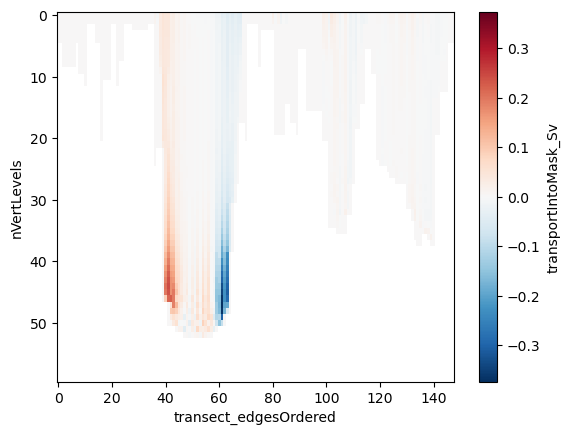

In [564]:
dss_transect_edges_vIM.transportIntoMask_Sv.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()

In [565]:
print('Total transport into mask: ', dss_transect_edges_vIM.transportIntoMask_Sv.sum().values)

Total transport into mask:  -0.08964032527676546


# Since we want to look at transport per density class, we need to create density bins

## set up potential density so that it rests on nEdges and nVertLevelsP1

In [566]:
# now that we have transport calculated using an average of the TWO cells sitting on nEdges,
# we can do an ffill to replace all these nans with potentialDensity values of the last ocean cell above them
# this enables us to do an interpolation followed by an xgcm transorm to get transport by density class

# ffill (vertical direction), mean(dim='TWO') (get on nEdges instead of nCells)
dss_transect_edges_vIM['timeMonthly_avg_potentialDensity_Edge']= dss_transect_edges_vIM.timeMonthly_avg_potentialDensity.ffill(dim='nVertLevels',limit=None).mean(dim='TWO')

# interpolate the potential density values onto nVertLevelsP1 coordinates
# create an xgcm grid
grid = Grid(dss_transect_edges_vIM, coords={'Z':{'center':'nVertLevels','outer':'nVertLevelsP1'}},periodic=False,autoparse_metadata=False)

# interpolate
dss_transect_edges_vIM['timeMonthly_avg_potentialDensity_EdgeP1'] = grid.interp(dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge, 'Z', boundary='extend')

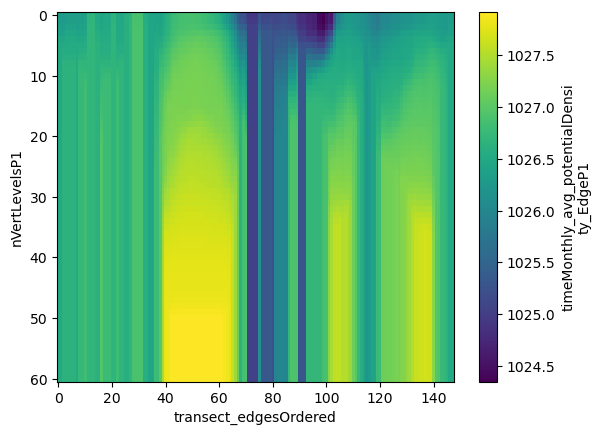

In [567]:
dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1.mean(dim='xtime_startMonthly').swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevelsP1')
plt.gca().invert_yaxis()

In [568]:
print('min potential density: ', dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1.min().values)
print('max potential density: ', dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1.max().values)

min potential density:  1023.030029296875
max potential density:  1027.91796875


## use xgcm transform to convert from z coordinates to sigma coordinates

In [570]:
target_sigma = np.linspace(1022,1029,100)

# transform
transport_transformed_cons = grid.transform(dss_transect_edges_vIM.transportIntoMask_Sv,
                                            'Z',
                                            target_sigma,
                                            method='conservative',
                                            target_data = dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1)

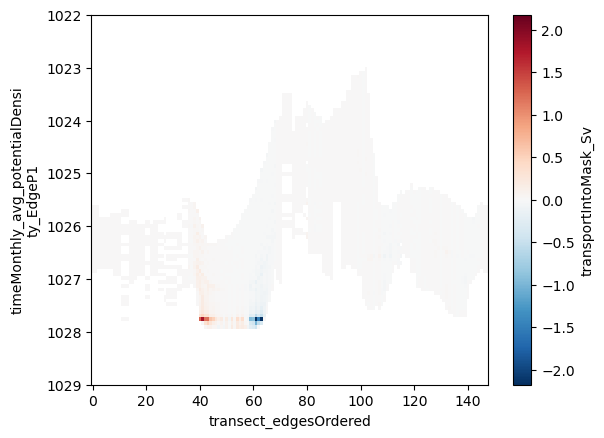

In [571]:
transport_transformed_cons.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(x='transect_edgesOrdered')
plt.gca().invert_yaxis()

In [572]:
total_transport_Edge = transport_transformed_cons.sum('nEdges').mean(dim=['xtime_startMonthly','TWO'])


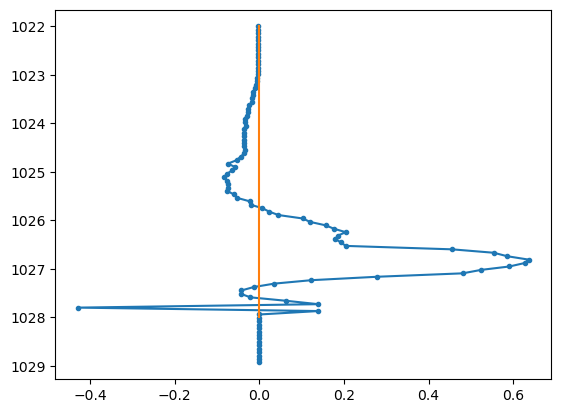

In [573]:
# we want to cumsum from bottom to top

# flip the array so bottom is now the first index
np.flipud(total_transport_Edge)

# cumsum this new array (this cumsums bottom (index=0) to top (index=49)
np.flipud(total_transport_Edge).cumsum()

# flip the array again to get cumsum bottom values back at the last index
cs_total_transport_Edge = np.flipud(np.flipud(total_transport_Edge).cumsum(axis=0))

plt.plot(cs_total_transport_Edge, target_sigma[0:99],marker='.')
plt.gca().invert_yaxis()
plt.plot(np.zeros(2), np.array([1022,1028]))